In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "Drug",
            'fairness_agg': 'mean',
            # 'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 3,
            'epochs_per_task': 25,
            'per_task_examples': np.inf,
            # 'per_task_examples': 10000,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 1.0,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:6' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.002,
            'metric' : "DP",
            'lambda': 0.1,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=Drug/seed=0_epoch=25_lr=0.001_alpha=0.002_tau=1.0


In [2]:
from datasets import MNIST
from datasets import FashionMNIST
from datasets import CIFAR10, CIFAR100
from datasets.drug import Drug

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'CIFAR10':
    benchmark = CIFAR10(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'CIFAR100':        
    benchmark = CIFAR100(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'Drug':        
    benchmark = Drug(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        joint = params['random_class_idx'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (12)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



In [3]:
from algorithms.imbalance import Heuristic2
from algorithms.sensitive import Heuristic3
from metrics import FairMetricCollector
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = Heuristic3(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = FairMetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])


In [4]:
# from trainers import ContinualTrainer
from trainers.fair_trainer import FairContinualTrainer2 as ContinualTrainer
# from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


In [5]:
if params['fairness_agg'] == "mean":
    agg = np.mean
elif params['fairness_agg'] == "max":
    agg = np.max
else:
    raise NotImplementedError

fairness_metrics = ["std", "EER", "EO", "DP"]
for metric in metric_manager_callback.meters:
    if metric in fairness_metrics:
        metric_manager_callback.meters[metric].agg = agg


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.056910569105691054, 'loss': 0.009496929719276036, 'std': 0.056910569105691054, 'EER': -1, 'EO': [0.08383458646616541, 0.0], 'DP': -1, 'accuracy_s0': 0.08928571428571429, 'accuracy_s1': 0.04736842105263158, 'classwise_accuracy': {0: array([ 14, 123]), 1: array([ 0, 71])}, 'DP_ingredients': {'class_pred_count_s0': {5: 37, 0: 13, 2: 11, 3: 1}, 'class_pred_count_s1': {5: 63, 3: 27, 0: 15, 2: 27}, 'class_pred_count': {5: 100, 3: 28, 0: 28, 2: 38}, 'count_s0': 62, 'count_s1': 132, 'count': 194}}
[2] Eval metrics for task 1 >> {'accuracy': 0.483739837398374, 'loss': 0.008856236934661865, 'std': 0.483739837398374, 'EER': -1, 'EO': [0.04210526315789476, 0.0], 'DP': -1, 'accuracy_s0': 0.5, 'accuracy_s1': 0.4789473684210526, 'classwise_accuracy': {0: array([119, 123]), 1: array([ 0, 71])}, 'DP_ingredients': {'class_pred_count_s0': {0: 61, 5: 1}, 'class_pred_count_s1': {0: 126, 2: 3, 5: 3}, 'c

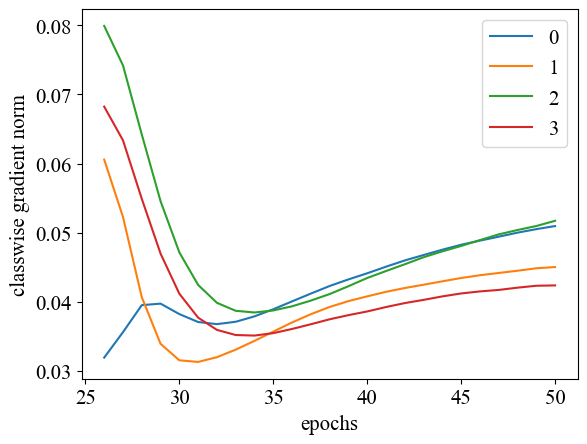

---------------------------- Task 3 -----------------------
Elapsed time(grad):0.982
losses=tensor([[1.1607, 0.9550, 1.3337, 1.2285, 4.1312, 3.9032, 0.9978, 1.1971, 1.2877,
         1.4391, 4.1842, 4.0264]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):0.212
Fairness:[ 1.22763276e-02  6.04867835e-03  7.27775844e-03 -6.35127055e-05
 -3.06374426e-02 -4.50532676e-02]
Current class expected loss:[ 0.          0.          0.          0.         -0.18348028 -0.16655039]
len(updated_seq_indices)=555
[51] Eval metrics for task 1 >> {'accuracy': 0.4966220084736058, 'loss': 0.006282590713697611, 'std': 0.031833276079239664, 'EER': -1, 'EO': [0.2368839427662957, 0.2218045112781955], 'DP': -1, 'accuracy_s0': 0.4726890756302521, 'accuracy_s1': 0.465149359886202, 'classwise_accuracy': {1: array([33, 71]), 0: array([ 65, 123])}, 'DP_ingredients': {'class_pred_count_s0': {3: 7, 1: 32, 0: 18, 2: 5}, 'class_pred_count_s1': {1: 30, 0: 72, 2: 18, 3: 12}, 'class_pred_count': 

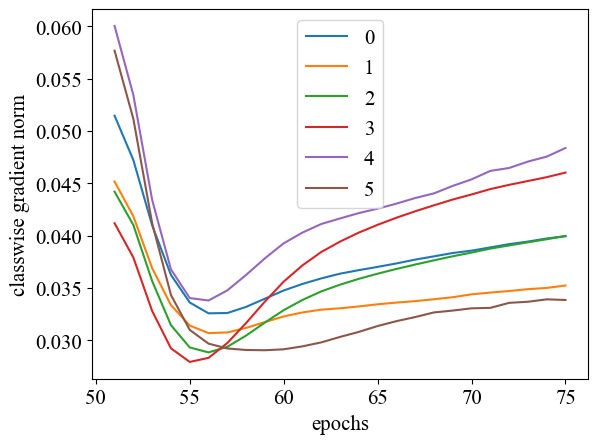

final avg-acc 0.31971402898455775
final avg-forget 0.16482892481739297


In [6]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [7]:
import copy
task_weight = copy.deepcopy(algorithm.weight_all)

num_bin = 20
np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin)

def bin(w: np.array, num_bin=20):
    out = dict()
    for r in np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin):
        r = np.round(r, 2)
        out[r] = np.sum(np.logical_and(w<=r, r-1/num_bin<w))
    out[1/num_bin] += np.sum(w==0)
    kk = list(out.keys())
    for k in kk:
        if out[k] == 0:
            del(out[k])
    return out


binned_weight = dict()
for i, wt in enumerate(task_weight):
    if i==0:
        continue
    print(f"task:{i+1}")
    binned_weight[i+1] = list()
    for we in wt:
        binned_weight[i+1].append({k: bin(we[k]) for k in we})




task:2
task:3


In [8]:
def bin(w: np.array, num_bin=20):
    out = dict()
    for r in np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin):
        r = np.round(r, 2)
        out[r] = np.sum(np.logical_and(w<=r, r-1/num_bin<w))
    out[1/num_bin] += np.sum(w==0)
    kk = list(out.keys())
    for k in kk:
        if out[k] == 0:
            del(out[k])
    return out

In [9]:
binned_weight = dict()
for i, wt in enumerate(task_weight):
    if i==0:
        continue
    print(f"task:{i+1}")
    binned_weight[i+1] = list()
    for we in wt:
        binned_weight[i+1].append({k: bin(we[k]) for k in we})

task:2
task:3


In [10]:
binned_weight

{2: [{0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}},
  {0: {1.0: 154}, 1: {1.0: 184}}],
 3: [{0: {1.0: 372}, 1: {1.0: 183}},
  {0: {1.0: 372}, 1: {1.0: 183}},
  {0: {1.0: 372}, 1: {1.0: 183}},
  {0: {1.0: 372}, 1: {1.0: 183}},
  {0: {

In [11]:
metric_manager_callback.meters['accuracy'].get_data()

array([[0.5  , 0.   , 0.   ],
       [0.462, 0.338, 0.   ],
       [0.46 , 0.048, 0.451]])

In [12]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

0.4065520788646704

In [13]:
[np.round(x, 3) for x in metric_manager_callback.meters['EO'].compute_overall()]

[0.0, 0.153, 0.087]

In [14]:
np.mean(metric_manager_callback.meters['EO'].compute_overall())

0.07998381409433236

In [15]:
[np.round(x, 3) for x in metric_manager_callback.meters['DP'].compute_overall()]

[0.0, 0.059, 0.057]

In [16]:
np.mean(metric_manager_callback.meters['DP'].compute_overall())

0.03859423797863137